# Tarea Semanal 3

## Modelizando un ADC

### Introduccion

En este trabajo vamos a realizar la simulacion digital de un ADC para lo cual estamos generando una señal senoidal a la cual le vamos a agregar un ruido analogico. Luego de obtenida la señal con la que estamos trabajando queremos cuantizarla de esta manera simulando el trabajo que realiza un ADC al colocarle una señal para que esta pase del terreno analogico al digital. 

Esto nos permite llevar una señal tomada por un aparato, como por ejemplo un sensor, y luego trabajarla digitalmente interpretando una interrupcion del mismo. Veamos como llevamos esto en nuestro codigo

## a) Generar el siguiente resultado producto de la experimentación. B = 4 bits, kn=1


Vamos a generar el codigo en Spyder requerido para esto. El codigo se encuentra comentado indicando que se hizo en cada paso. En posteriores iteraciones del codigo vamos a remover los comentarios para comprimir dicho codigo


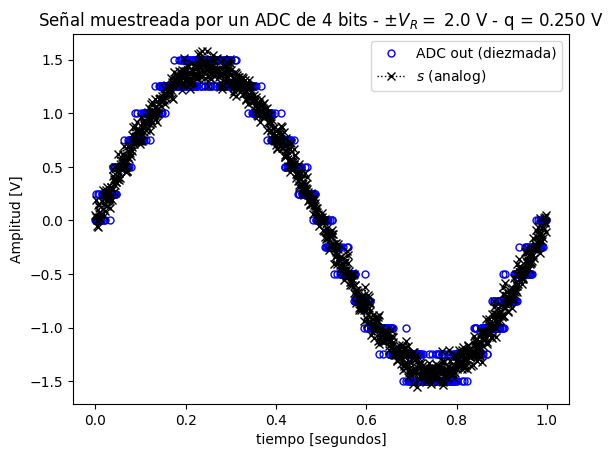

Text(0.5, 0, 'Pasos de cuantización (q) [V]')

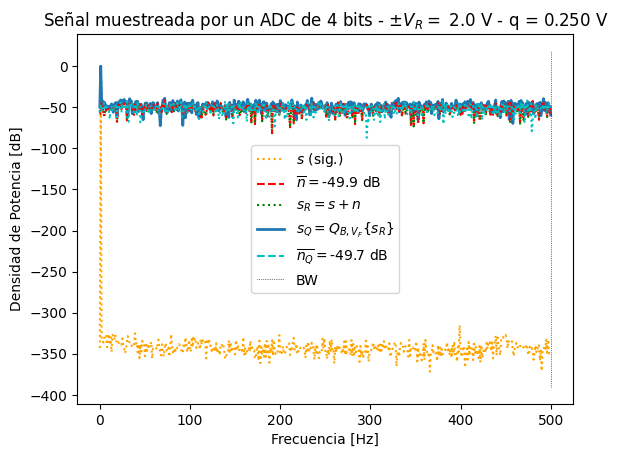

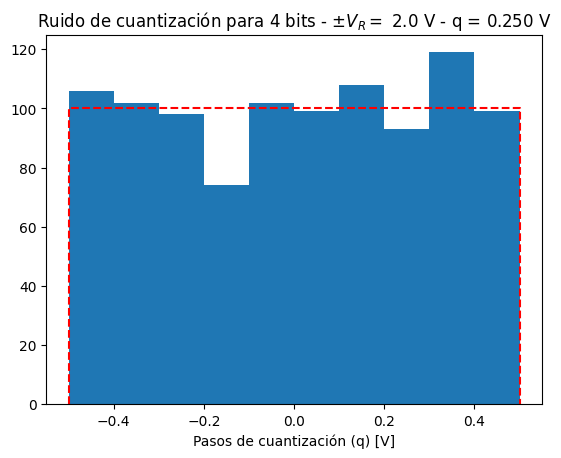

In [7]:
#%% 

""" 

TAREA SEMANAL 3 - Modelizado de un ADC

"""

#%% módulos y funciones a importar

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

#%% Datos de la simulación

fs = 1000           # frecuencia de muestreo (Hz)
N = 1000            # cantidad de muestras

# Datos del ADC 
B =  4             # bits
Vf = 2             # rango simétrico de +/- Vf Volts ; esto seria +- Vref
q = Vf/2**(B-1)     # paso de cuantización de q Volts 2 a la b-1


# datos del ruido (potencia de la señal normalizada, es decir 1 W)
# Esta potencia la obtenemos al asegurar varianza 1

pot_ruido_cuant = q**2 / 12                 # Watts, esto va a ser la varianza de mi señal de ruido 
kn = 1                                      # Escala de la potencia de ruido analógico
pot_ruido_analog = pot_ruido_cuant * kn     # Ahora, con esto podemos escalar el ruido para aumentar o disminuir

ts = 1/fs           # tiempo de muestreo
df = fs/N           # resolución espectral

#%% Genero mi señal senoidal

# Amplitud,         Amplitud maxima
# f0,               Frecuencia de la señal
# Fase,             Fase de la señal
# Num_Muestras      Cantidad de muestras tomadas por el ADC
# Fs,               Frecuencia de muestreo

def Generador_Senoidal ( Amplitud, f0, Fase, Num_Muestras, fs ):
    
    # Calculamos el tiempo de sampleo
    ts = 1/fs
    
    # Grilla de sampleo temporal
    tt = np.linspace(0, (Num_Muestras-1)*ts, Num_Muestras)
    
    Seno_Generado = Amplitud * np.sin( 2 * np.pi * f0 * tt + Fase )
    
    return tt, Seno_Generado

#%% Busco los valores para los cuales esta senoidal esta normalizada, es decir que la señal tiene una varianza = 1

# Como la varianza es una senoidal es x(t) = A sen ( wt + phi ), la varianza va a estar dada por Var(x) = A^2 * 1/2 

A = np.sqrt(2)
Vmed = 0
f0 = fs/N
Phi = 0    

tt,analog_sig = Generador_Senoidal( Amplitud= A, f0= f0, Fase= Phi, Num_Muestras= N, fs= fs )

# tt es la grilla temporal

varianza = np.var(analog_sig)

# Compruebo que la varianza es =1, entonces ya tengo mi señal normalizada en este punto

#%% Ahora, queremos sumar la señal de ruindo a esta senoidal

# Para poder general la señal de ruido, tenemos que tener una distribucion normal con un N(o,sigma)

Media = 0                   # Media
Sigma2 = pot_ruido_analog   # Varianza
SD_Sigma = np.sqrt(Sigma2)  # Desvio standar 

# Recuerdo que la pot del ruido es= q^2/12

# Genero señal de ruido
nn = np.random.normal(Media, SD_Sigma, N)

varianza_ruido = np.var(analog_sig)

# Compruebo que la varianza es =1, entonces ya tengo mi señal de ruido normalizada en este punto

#%% Ahora genero mi señal de entrada al ADC

# Señales

# analog_sig ,  señal analógica sin ruido
# nn ,          señal de ruido

# señal analógica de entrada al ADC (con ruido analógico)

sr = analog_sig + nn

# Observacion; como tengo una señal normalizada a la que luego de sumo un ruido. Puedo hacer esto
# ya que, este ruido obedece una distribucion normal con el sigma cuadrado

#%% Ya con la señal de ruido, vamos a cuantizarla

# Uso la funcion redondeo para aproximar el valor mas cercano de la funcion de ruido que estoy pasando 

# señal cuantizada sin escala original adimensional ( Si veo el grafico acá la escala esta en divisiones )
srq_1 = np.round(sr/q)

# Señal cuantizada llevada a escala original ( Con esto la vuelvo a llevar a +- 3v )
srq = srq_1 * q

# nn =  # señal de ruido de analógico
# nq =  # señal de ruido de cuantización

nq = sr - srq

#%% Visualización de resultados

# cierro ventanas anteriores
plt.close('all')

##################
# Señal temporal
##################

plt.figure(1)

plt.plot(tt, srq, lw=2, linestyle='', color='blue', marker='o', markersize=5, markerfacecolor='blue', markeredgecolor='blue', fillstyle='none', label='ADC out (diezmada)')
plt.plot(tt, sr, lw=1, color='black', marker='x', ls='dotted', label='$ s $ (analog)')

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.xlabel('tiempo [segundos]')
plt.ylabel('Amplitud [V]')
axes_hdl = plt.gca()
axes_hdl.legend()
plt.show()


###########
# Espectro
###########

# En esta parte usamos la FFT para poder tranformar las señales usando la FFT
# Los numeros que vamos a tener en ft_SR son numeros complejos, ya que, estamos usando FFT

plt.figure(2)
ft_SR = 1/N*np.fft.fft( sr )
ft_Srq = 1/N*np.fft.fft( srq )
ft_As = 1/N*np.fft.fft( analog_sig )
ft_Nq = 1/N*np.fft.fft( nq )
ft_Nn = 1/N*np.fft.fft( nn )

# grilla de sampleo frecuencial
ff = np.linspace(0, (N-1)*df, N)

bfrec = ff <= fs/2 
# Con esto eliminamos la mitad del vector de la FFT asi eliminamos las redundancias
# Este es un vector booleano que tiene True hasta N/2 valores y luego son todos False. 
# Ya que, la otra parte es simetrica

Nnq_mean = np.mean(np.abs(ft_Nq)**2)
nNn_mean = np.mean(np.abs(ft_Nn)**2)

plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_As[bfrec])**2), color='orange', ls='dotted', label='$ s $ (sig.)' )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB'.format(10* np.log10(2* nNn_mean)) )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $' )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\}$' )
plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB'.format(10* np.log10(2* Nnq_mean)) )
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nn[bfrec])**2), ':r')
plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
plt.plot( np.array([ ff[bfrec][-1], ff[bfrec][-1] ]), plt.ylim(), ':k', label='BW', lw = 0.5  )

plt.title('Señal muestreada por un ADC de {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q) )
plt.ylabel('Densidad de Potencia [dB]')
plt.xlabel('Frecuencia [Hz]')
axes_hdl = plt.gca()
axes_hdl.legend()

#############
# Histograma
#############

plt.figure(3)
bins = 10
plt.hist(nq.flatten()/(q), bins=bins)
plt.plot( np.array([-1/2, -1/2, 1/2, 1/2]), np.array([0, N/bins, N/bins, 0]), '--r' )
plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))

plt.xlabel('Pasos de cuantización (q) [V]')


### Analicemos lo obtenido 

En el primer grafico podemos ver la señal que ha sido cuantizada por nuestro ADC. En la cual podemos ver las aproximaciones que se han realizado para acercarse a los valores permitidos por el ADC de 4 Bits, esto implica que tenemos menos divisiones horizontales, o niveles de energia a los cuales el ADC puede aproximar a la señal, lo que hace que nuestra resolucion sea limitada. Si aumentamos los Bits, vamos a tener mas posibilidades de tener mas valores en los cuales el ADC puede aproximar a la señal. 

En el segundo grafico podemos observar el grafico de densidad de potencia de la señal que hemos cuantizado. Como podemos pensar esto ?

En primera instancia, tenemos un pico ubicado a 1 hz que va a ser la densidad de potencia del seno de 1 hz que estamos muestreando con el ADC. Es decir, toda la potencia de nuestra señal se esta ubicando allí. 
Por otro lado, si la señal esta ubicada en 1 hz, porque seguimos teniendo un grafico de la señal en el resto del espectro ? Esto se debe a que como estamos agregando una señal de ruido, esta es valida para todo el espectro. Por ese motivo, tenemos a nuestro pico en 1 hz y en el resto del espectro tenemos el ruido analogico que esta siendo representado por el ADC. 

Adicionalmente observamos que tenemos 3 pisos de ruido. El analogico, digital y el de la representacion que podemos ver en colores rojo, azul y amarillo respectivamente. 
Los primeros 2 estan dados por como estamos representando a la señal en la parte analogica, es decir, como seria nuestro aparato físico que esta tomando la señal y que ruido mete a la señal que originalmente queremos representar. Luego, el digital esta originado cuando queremos digitalizar esa señal que estamos tomando analogicamente. 
Pensemoslo de esta manera, imaginemos que queremos tomar la señal cardiaca de una persona. Para ello, vamos a tener un aparato que colocamos en ella que va a ser el encargado de recolectar dicha señal; el ruido que es generado por esta parte es el piso de ruido analogico. Por otro lado, una vez tomamos la señal con nuestra circuiteria y la conectamos al ADC para digitalizarla vamos a tener un ruido generado por la propia representacion del ADC al aproximar a la señal a uno de los posibles valores que este puede tomar, esto va a dar nuestro piso de ruido digital.

En este caso, podemos observar que ambos ruidos estan al mismo nivel ( aproximadamente - 40dB ). Esto es de especial utilidad, ya que, si nos esforzamos por tener una circuiteria muy robusta que no genere ruido al tomar la señal pero nuestro ADC no es de buena calidad todo ese esfuerzo se ve opacado por el ruido digital que va a provocar el ADC. Esto es debido a que pido de ruido mas alto que tengamos va a determinar el ruido de la representacion de la señal, por lo que, en este caso si el piso de ruido digital fuese 20 db mas alto que en el analogico, la señal de salida va a estar representada por este ruido digital mas alto, por mas que el analotico sea mucho menos. 

Ahora, a que hace referencia el piso de ruido amarillo ? Esto es el propio ruido que vamos a tener por la representacion de nuestra señal en la computadora. En el caso de sistemas con un hardware potente, es un ruido muy pequeño ( -350 db ) debido a que el ruido que pone esta representacion es muy pequeño. Acá podemos lo que hablamos antes, donde por mas que este ruido es mucho menor que los otros 2 la señal de salida va a estar determinada por el piso de ruido mas alto que tengamos. 

Finalmente, el ultimo grafico vemos que el ruido de nuestra cuantización tiene una distribucion uniforme. Por mas, que el ruido analogico que originalmente sumamos a la señal obedece a una distribucion normal. Es decir, que por mas que no generamos un ruido con una distribucion uniforme el resultado que obtuvimos es igual a lo que vimos en la teoria que indica este resultado. 



## b) Analizar para una de las siguientes configuraciones B = ̣{4, 8 y 16} bits, kn={1/10,1,10}. Discutir los resultados respecto a lo obtenido en a).

Generemos los codigos para obtener estas representaciones:

Disclaimer, me ayude con chat GPT para generar los subplots para cada una de las combinaciones

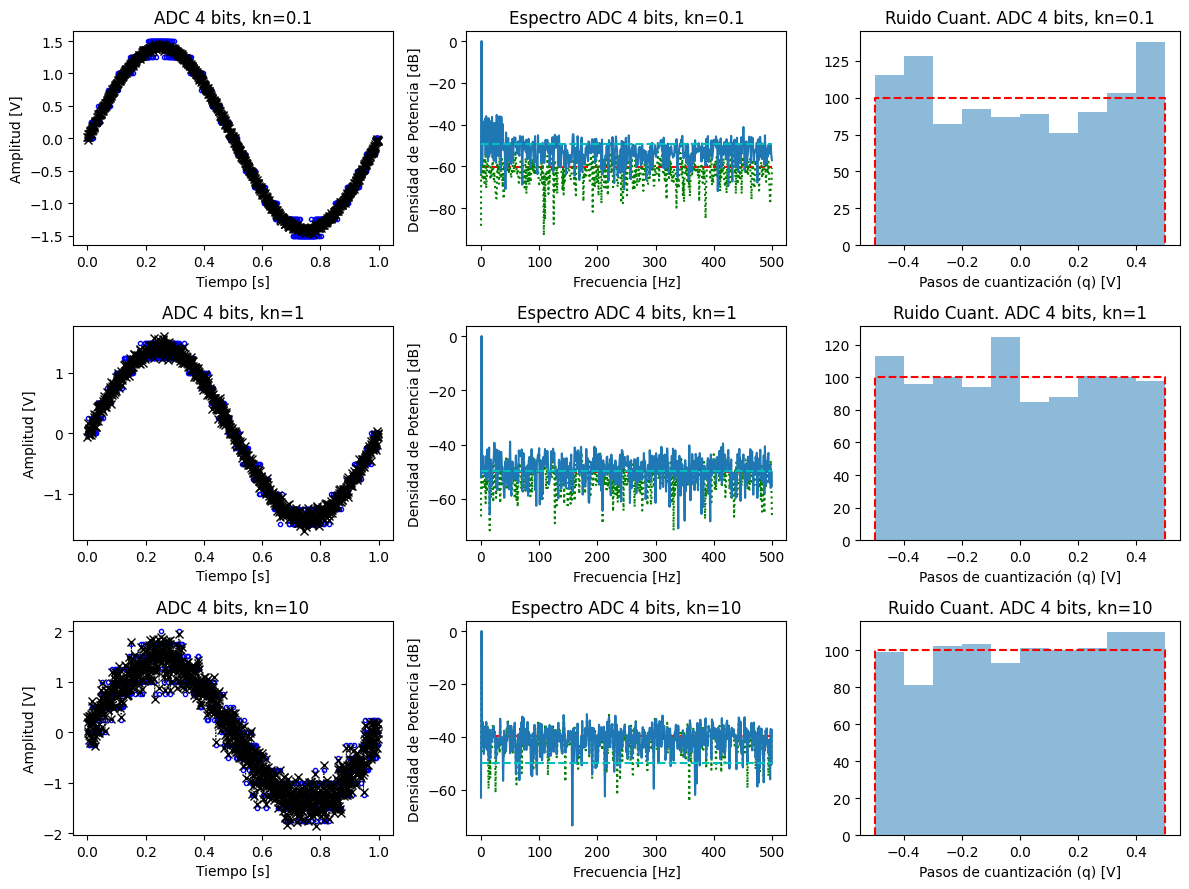

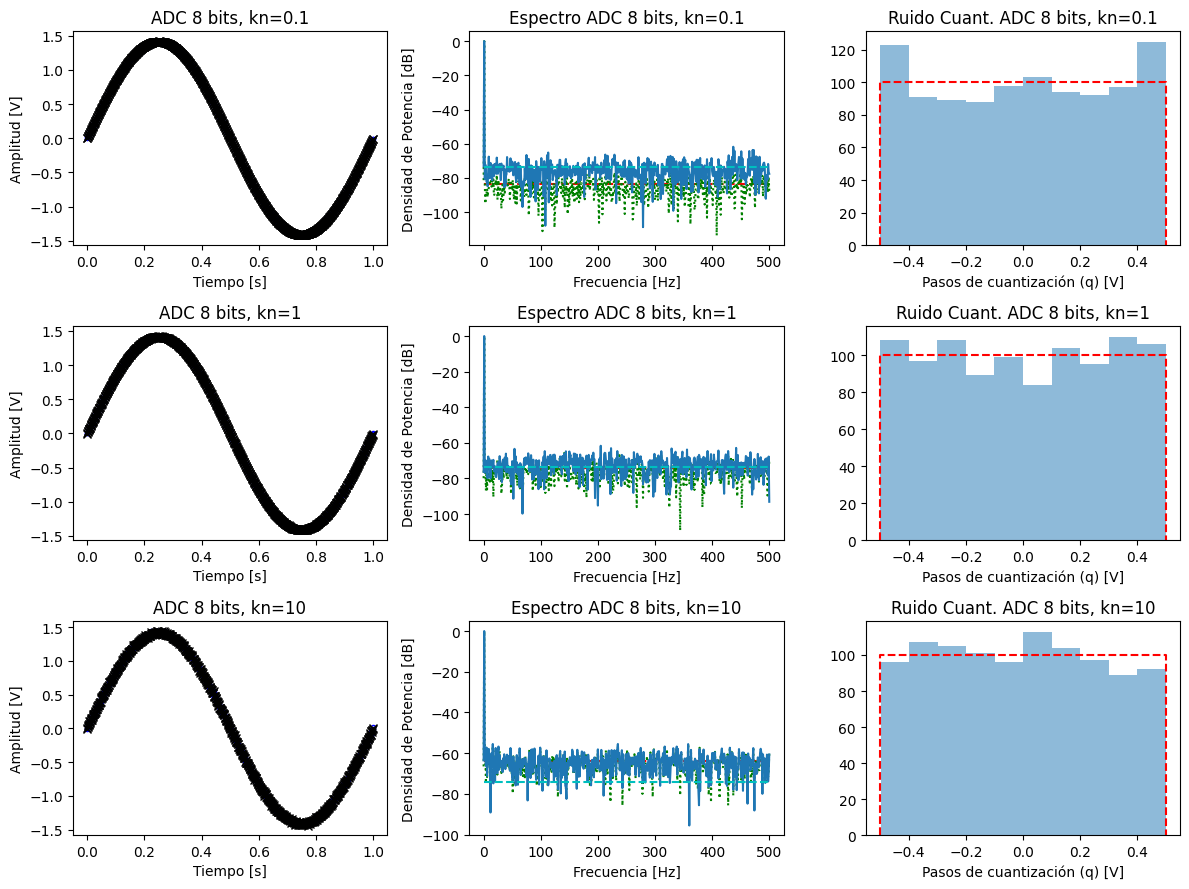

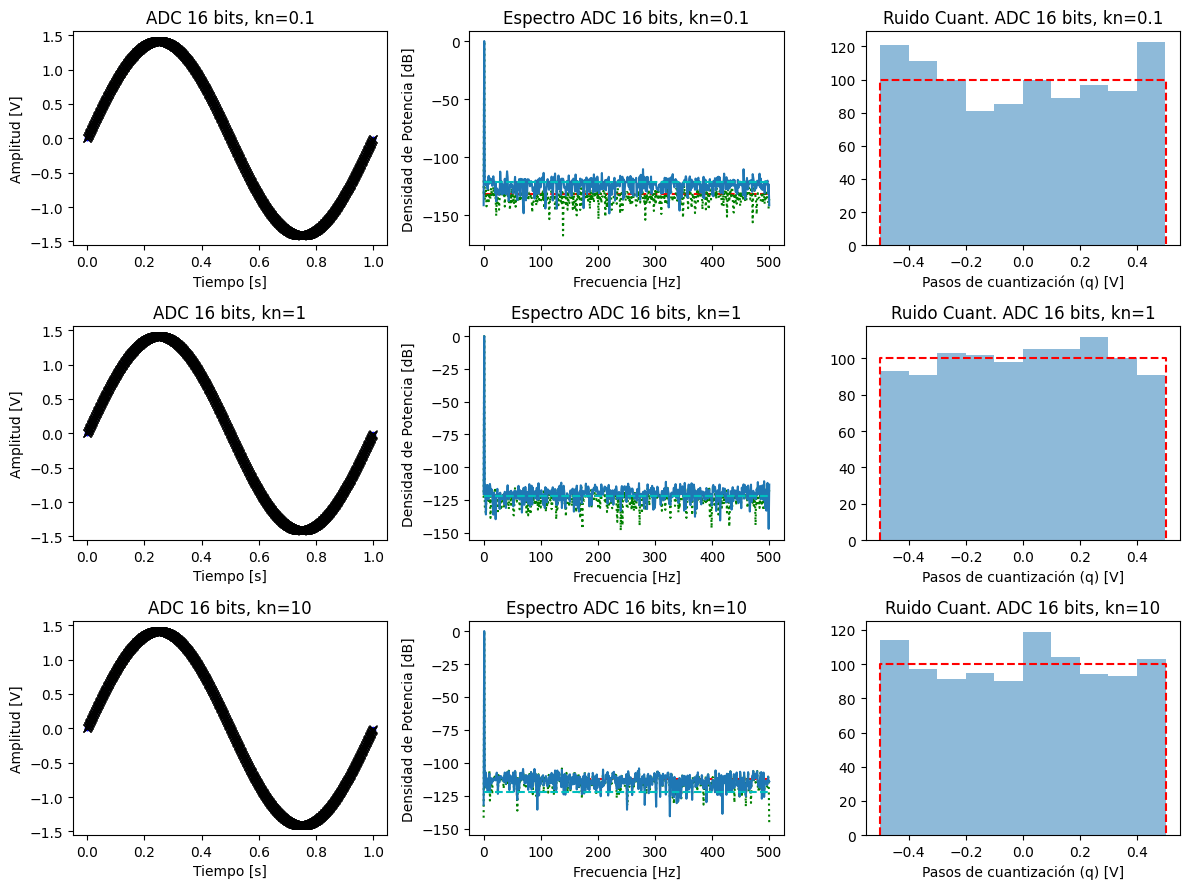

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def generar_graficos(B):
    # Datos de la simulación
    fs = 1000  # Frecuencia de muestreo (Hz)
    N = 1000   # Cantidad de muestras
    kn_valores = [1/10, 1, 10]  # Escala de la potencia de ruido analógico
    Vf = 2  # Rango simétrico de +/- Vf Volts

    ts = 1/fs  # Tiempo de muestreo
    df = fs/N  # Resolución espectral
    
    # Generador de señal senoidal
    def Generador_Senoidal(Amplitud, f0, Fase, Num_Muestras, fs):
        ts = 1/fs
        tt = np.linspace(0, (Num_Muestras-1)*ts, Num_Muestras)
        Seno_Generado = Amplitud * np.sin(2 * np.pi * f0 * tt + Fase)
        return tt, Seno_Generado

    A = np.sqrt(2)
    f0 = fs/N
    Phi = 0    
    tt, analog_sig = Generador_Senoidal(Amplitud=A, f0=f0, Fase=Phi, Num_Muestras=N, fs=fs)

    q = Vf / 2**(B-1)  # Paso de cuantización
    pot_ruido_cuant = q**2 / 12  # Potencia del ruido de cuantización
    
    # Crear figura con 3 filas y 3 columnas
    fig, axs = plt.subplots(3, 3, figsize=(12, 9))

    for j, kn in enumerate(kn_valores):
        pot_ruido_analog = pot_ruido_cuant * kn  # Escalar el ruido analógico
        
        # Generación de ruido
        Media = 0
        Sigma2 = pot_ruido_analog
        SD_Sigma = np.sqrt(Sigma2)
        nn = np.random.normal(Media, SD_Sigma, N)
        
        # Señal de entrada al ADC con ruido
        sr = analog_sig + nn  
        
        # Cuantización
        srq_1 = np.round(sr / q)
        srq = srq_1 * q  # Señal cuantizada
        nq = sr - srq  # Ruido de cuantización
        
        # Señal temporal
        axs[j, 0].plot(tt, srq, lw=1.5, linestyle='', color='blue', marker='o', markersize=3, fillstyle='none')
        axs[j, 0].plot(tt, sr, lw=0.8, color='black', marker='x', ls='dotted')
        axs[j, 0].set_title(f'ADC {B} bits, kn={kn}')
        axs[j, 0].set_xlabel('Tiempo [s]')
        axs[j, 0].set_ylabel('Amplitud [V]')
        
        # Espectro
        ft_SR = 1/N * np.fft.fft(sr)
        ft_Srq = 1/N * np.fft.fft(srq)
        ft_Nq = 1/N * np.fft.fft(nq)
        ft_Nn = 1/N * np.fft.fft(nn)
        
        # Grilla de frecuencia
        ff = np.linspace(0, (N-1)*df, N)
        bfrec = ff <= fs/2  # Filtrado de la mitad redundante
        
        # Promedios para la densidad de potencia
        Nnq_mean = np.mean(np.abs(ft_Nq)**2)
        nNn_mean = np.mean(np.abs(ft_Nn)**2)
        
        axs[j, 1].plot([ff[bfrec][0], ff[bfrec][-1]], 10*np.log10(2*np.array([nNn_mean, nNn_mean])), '--r')
        axs[j, 1].plot(ff[bfrec], 10*np.log10(2*np.abs(ft_SR[bfrec])**2), ':g')
        axs[j, 1].plot(ff[bfrec], 10*np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=1.5)
        axs[j, 1].plot([ff[bfrec][0], ff[bfrec][-1]], 10*np.log10(2*np.array([Nnq_mean, Nnq_mean])), '--c')
        axs[j, 1].set_title(f'Espectro ADC {B} bits, kn={kn}')
        axs[j, 1].set_xlabel('Frecuencia [Hz]')
        axs[j, 1].set_ylabel('Densidad de Potencia [dB]')
        
        # Histograma
        bins = 10
        axs[j, 2].hist(nq.flatten() / q, bins=bins, alpha=0.5)
        axs[j, 2].plot([-1/2, -1/2, 1/2, 1/2], [0, N/bins, N/bins, 0], '--r')
        axs[j, 2].set_title(f'Ruido Cuant. ADC {B} bits, kn={kn}')
        axs[j, 2].set_xlabel('Pasos de cuantización (q) [V]')

    # Ajuste de diseño
    plt.tight_layout()
    plt.show()

# Generar gráficos para cada B
for B in [4, 8, 16]:
    generar_graficos(B)

En este caso, sacamos el ruido de la representacion de los graficos de densidad de potencia asi tenemos una mejor una mejor vision de los pisos de ruido analogico y digital.

Ahora, podemos ver que a medida que aumentamos los Bits del ADC mejora enormemente la digitalizacion de la señal. Y como en este caso tenemos que el ruido analogico esta relacionado con los bits debido a que:

 $$ q = \frac{V_f}{2^{B-1}} $$ 
$$ pot-ruido-cuant = \frac{q^2}{12} $$

Entonces, a una mayor cantidad de bits menor va a ser la influenvia del ruido en la salida de nuestra señal. Por esto, vemos que con 4 bits y Kn = 1 los pisos de ruido estan aproximadamente en -50 dB, pero en cambio con 16 bits y Kn = 1 observamos al piso en aproximadamente -120 dB. Esto es enormemente mejor teniendo un ruido que es 7 ordenes de magnitud menor con un ADC de 16 bits. 

Por otro lado, al cambiar al Kn vemos que los pisos de ruido ya no estan alineados y dependiendo el valor vamos a tener el piso analogico mas arriba o el digital mas arriba. Esto encadena con lo ante mencionado, en donde no importa que un piso sea menor que el otro ya que la señal de salida ( En azul ) va a estar determinada por el piso mas alto. Adicionalmente, al ir teniendo ruidos mas atenuados con el aumento de los Bits del ADC la señal de salida es mas uniforme ya que la presencia del ruido es menor. Esto tambien lo vemos claramente en los graficos de la señal cuantizada que mas Bits el grafico es mas parecido a la senoidal que estamos generando originalmente.

Tambien vemos que en todos los casos la distribucion del ruido de cuantizacion se parece a una uniforme, pero a mas Bits mejor es este parecido. En donde observamos que los Bins estan mas cerca de la linea que marca la caja de la uniforme. 

## Conclusion 

De todo esto puedo destacar 3 grandes puntos que pude analizar luego de realizar estas representaciones:

1) Es importante que los pisos de ruido analogico y digital sean lo mas parecidos posibles. Esto debido a que, no vale la pena esforzarse para tener uno mas bajo que el otro ya que a la hora de representar a la señal esta va a estar limitada por el ruido que sea mas alto. Es decir, que al diseñar un sistema digitalice una señal voy a tener en cuenta cual parte va a estar metiendo mas ruido segun lo que tengo disponible y en consecuencia diseñar la otra parte acorde a esta limitante que tengo

2) Es bueno invertir en tener mas Bits en nuestro ADC, ya que pude ver a simple vista que pasando de 4 a 16 bits se redujo enormemente la influencia del ruido, siendo 7 ordenes de magnitudes menor al tener mas Bits. Teniendo en cuenta lo anterior, si mi parte analogica me limita poniendo un ruido mayor ahi si no invertiria con mas Bits, sino pondria los acorde a la limitante del sistema

3) Me sorprendió ver que a pesar de no haber puesto un ruido con distribucion uniforme, este emergió al cuantizar la señal tal y como indicaba la teoria. Es ver algo que veiamos en los libros traido a la realidad





## Bonus

###💎 Encontrar la relación entre la cantidad de B bits del ADC y el SNR de la señal digitalizada. (Ver Holton. DSP Principles and App. 6.7 ADC Quantization pag. 387 )

Se puede ver que la relacion entre la cantidad de bits del ADC y el Signal to Noise Ratio esta dada por la siguiente formula:

$$ SNR \approx (6,02*Bits) + 1,76 [dB] $$

Esto implica que mientras mas Bits tengamos mas alto es el SNR:

$$ 8 Bits \Rightarrow SNR \approx (6,02*8) + 1,76 = 48,92 db $$
$$ 16 Bits \Rightarrow SNR \approx (6,02*8) + 1,76 = 98,08 db $$

Y queremos que el SNR sea lo mas alto posible, ya que, esto implica que la señal es mucho mas fuerte que el ruido. Recordemos que le SNR esta dado por:

$$ SNR = 10 \log_{10} \left( \frac{P_{\text{señal}}}{P_{\text{ruido}}} \right) $$

Con todo esto podemos ver que duplicar la cantidad de bits reduce el error de cuantizacion lo que hace que la calidad de la señal de salida sea mucho mejor respecto al ruido. De esta manera y como vimos anteriormente en los graficos de nuestro ADC, la señal de salida con un ADC de 16 Bits es mucho mejor que con uno de 4 Bits

### 🤯 Simular el efecto del aliasing junto con el muestreo.

El efecto del aliasing viene dado cuando queremos muestrear una señal pero no seguimos el teorema del muestreo, en el cual, tomamos la precaucion que la frecuencia de muestreo sea mayor que el doble de nuestra frecuencia $ f_s \geq 2*f_0 $. A esto lo habiamos llamado la precuencia de Nyquist.

De esta manera, nos aseguramos que espectralmente no estemos solapando las repeticiones periodicas que vamos a tener del espectro de la señal y así no estamos pisando informacion.

Entonces, si no respetamos esta frecuencia de sampleo van a ocurrir los llamados efectos de aliasing. 

Vamos a simularlo:

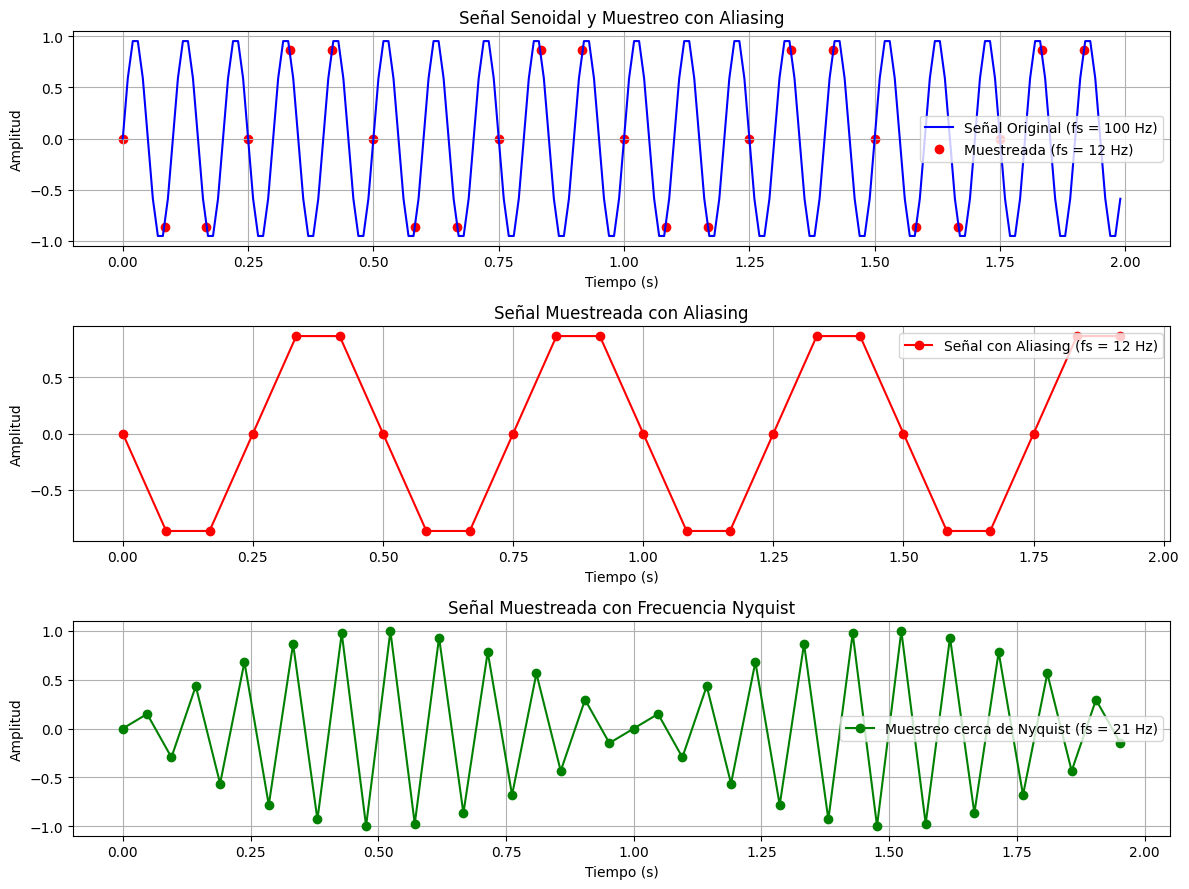

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la señal
f_signal = 10  # Frecuencia de la señal senoidal (Hz)
duration = 2  # Duración de la señal en segundos
fs_high = 100  # Frecuencia de muestreo alta (Hz) para referencia
fs_low = 12   # Frecuencia de muestreo baja (Hz) que provocará aliasing
fs_nyquist = 21  # Frecuencia de muestreo apenas por encima del criterio de Nyquist

# Generar señal continua de referencia
t_high = np.linspace(0, duration, int(fs_high * duration), endpoint=False)
signal_high = np.sin(2 * np.pi * f_signal * t_high)

# Muestreo con una frecuencia alta (sin aliasing)
t_low = np.linspace(0, duration, int(fs_low * duration), endpoint=False)
signal_low = np.sin(2 * np.pi * f_signal * t_low)

# Muestreo apenas por encima de Nyquist
t_nyquist = np.linspace(0, duration, int(fs_nyquist * duration), endpoint=False)
signal_nyquist = np.sin(2 * np.pi * f_signal * t_nyquist)

# Graficar las señales
plt.figure(figsize=(12, 9))

# Señal original con muestreo alto
plt.subplot(3, 1, 1)
plt.plot(t_high, signal_high, label=f'Señal Original (fs = {fs_high} Hz)', color='blue')
plt.scatter(t_low, signal_low, color='red', label=f'Muestreada (fs = {fs_low} Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.title('Señal Senoidal y Muestreo con Aliasing')
plt.grid()

# Señal muestreada reconstruida erróneamente
plt.subplot(3, 1, 2)
plt.plot(t_low, signal_low, marker='o', linestyle='-', color='red', label=f'Señal con Aliasing (fs = {fs_low} Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.title('Señal Muestreada con Aliasing')
plt.grid()

# Señal muestreada con frecuencia Nyquist
plt.subplot(3, 1, 3)
plt.plot(t_nyquist, signal_nyquist, marker='o', linestyle='-', color='green', label=f'Muestreo cerca de Nyquist (fs = {fs_nyquist} Hz)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.title('Señal Muestreada con Frecuencia Nyquist')
plt.grid()

plt.tight_layout()
plt.show()


Viendo estos 3 graficos podemos entender un poco mejor como es el efecto del Aliasing al no muestrear correctamente una señal. Como es esto ?

En el primero tenemos a la señal senoidal correctamente muestreada siendo la fs = 100 hz y la f0 = 10 hz. En donde cumplimos con creces el criterio de nyquist. De esta manera, vemos que el muestreo nos arroja una señal en la cual podemos apreciar correctamente la forma de una senoidal a 10 hz 

Luego, en segundo lugar tenemos un muestreo con una fs = 12 hz, en el cual vemos que la señal muestreada no tiene el aspecto de una senoidal y al tratar de muestrearla no tenemos la informacion suficiente para poder tener una representacion fidedigna de la señal original. Esto es el antes mencionado efecto del aliasing al muestrear una señal 

Finalmente, que pasa si justo estamos muestreando cerca de Nyquist ? Por mas que la fs = 21hz es suficiente la reconstruccion que hacemos la muestrearla no tiene la calidad que teniamos al hacerlo con 100 hz. Si bien, podemos apreciar que se trata de uan señal senoidal no podemos ver con claridad la forma, por lo que, la reconstruccion que hacemos tiene la informacion suficiente para saber que tenemos una senoidal. Por esto, es que se recomeinda muestrar con una frecuencia mucho mayor que la de nyquist y así tener la mayor cantidad posible de informacion de la señal original. 